In [1]:
import os
import re
import sent2vec
import numpy as np
from numpy import linalg as LA
from nltk.tokenize.stanford import StanfordTokenizer

import matplotlib.pylab as plt
import seaborn as sns
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
def cosineDist(u, v):
    return np.dot(u, v)/(LA.norm(u)*LA.norm(v))

In [3]:
BASE_SNLP_PATH = os.path.abspath("./stanford-postagger")
SNLP_TAGGER_JAR = os.path.join(BASE_SNLP_PATH, "stanford-postagger.jar")
MODEL_WIKI_UNIGRAMS = MODEL_WIKI_BIGRAMS = MODEL_TORONTOBOOKS_UNIGRAMS = MODEL_TORONTOBOOKS_BIGRAMS = MODEL_TWITTER_UNIGRAMS = MODEL_TWITTER_BIGRAMS = os.path.abspath(".")

In [4]:
def tokenize(tknzr, sentence, to_lower=True):
    """Arguments:
        - tknzr: a tokenizer implementing the NLTK tokenizer interface
        - sentence: a string to be tokenized
        - to_lower: lowercasing or not
    """
    sentence = sentence.strip()
    sentence = ' '.join([format_token(x) for x in tknzr.tokenize(sentence)])
    if to_lower:
        sentence = sentence.lower()
    sentence = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))','<url>',sentence) #replace urls by <url>
    sentence = re.sub('(\@ [^\s]+)','<user>',sentence) #replace @user268 by <user>
    filter(lambda word: ' ' not in word, sentence)
    return sentence

def format_token(token):
    """"""
    if token == '-LRB-':
        token = '('
    elif token == '-RRB-':
        token = ')'
    elif token == '-RSB-':
        token = ']'
    elif token == '-LSB-':
        token = '['
    elif token == '-LCB-':
        token = '{'
    elif token == '-RCB-':
        token = '}'
    return token

def tokenize_sentences(tknzr, sentences, to_lower=True):
    """Arguments:
        - tknzr: a tokenizer implementing the NLTK tokenizer interface
        - sentences: a list of sentences
        - to_lower: lowercasing or not
    """
    return [tokenize(tknzr, s, to_lower) for s in sentences]

In [5]:
'''sentences = [
    "Delete file",
    "Delete this file",
    "Remove file",
    "Remove this file",
    "Remove files",
    "Erase file",
    "Create file",
    "Create folder",
    "Move file",
    "Copy file",
    "What is the time",
    "Time please",
    "What is the date",
    "Search the web",
    "List directory",
    "List files and folders",
    "List files",
    "Whats in this directory",
    "Change directory",
    "Locate a file",
    "Search for file"
]'''
sentences = [
    "Delete file",
    "Remove file",
    "Erase file",
    "Create file",
    "Create folder",
    "Move file",
    "Copy file",
    "What is the time",
    "Time please",
    "What is the date",
    "List directory",
    "List files and folders",
    "Whats in this directory",
    "Change directory",
    "Search the web",
    "Locate a file",
    "Search for file"
]

tknzr = StanfordTokenizer(SNLP_TAGGER_JAR, encoding='utf-8')
s = ' <delimiter> '.join(sentences)
tokenized_sentences_SNLP = tokenize_sentences(tknzr, [s])
tokenized_sentences_SNLP = tokenized_sentences_SNLP[0].split(' <delimiter> ')

/home/saif/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.parse.corenlp.CoreNLPTokenizer instead.'


In [6]:
model = sent2vec.Sent2vecModel()
model.load_model("models/wiki_unigrams.bin")

In [7]:
vectors = model.embed_sentences(tokenized_sentences_SNLP)
print(vectors.shape)

(17, 600)


In [12]:
def euclidSimilarity(u, v):
    return LA.norm((u/LA.norm(u))-(v/LA.norm(v)))

In [13]:
corrMat = np.ndarray((len(vectors), len(vectors)), dtype='float32')
for i, u in enumerate(vectors):
    for j, v in enumerate(vectors):
        corrMat[i][j] = euclidSimilarity(vectors[i], vectors[j])

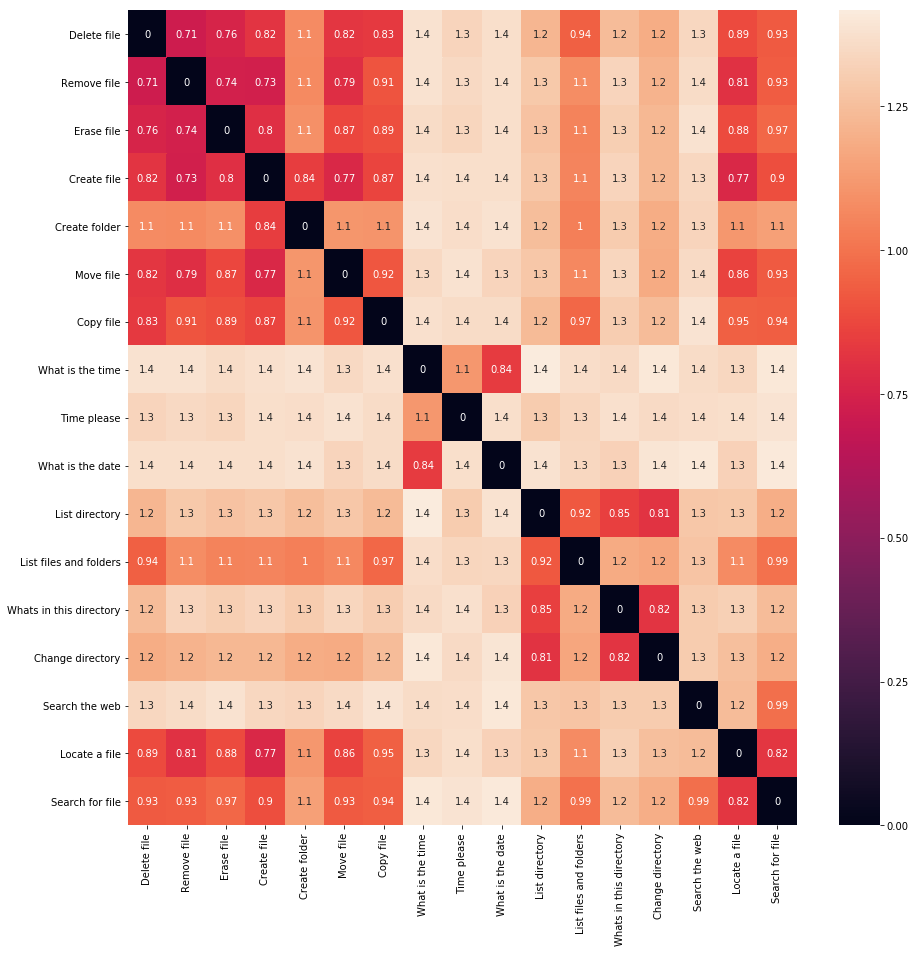

In [14]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrMat, ax=ax, annot=True, xticklabels=sentences, yticklabels=sentences)
fig.savefig("heatmap.png", bbox_inches='tight')

In [17]:
help(sent2vec.Sent2vecModel.embed_sentences)

Help on method_descriptor:

embed_sentences(...)



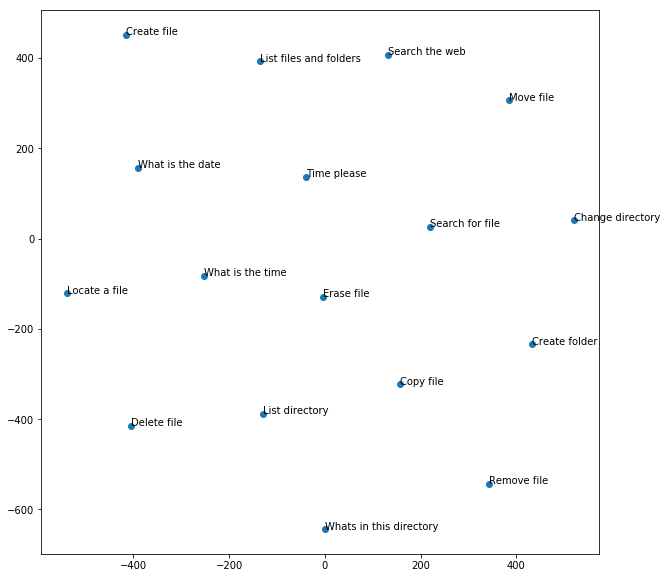

In [18]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500)
two_d_embeddings = tsne.fit_transform(vectors)

fig = plt.figure(figsize=(10,10))  # in inches
ax = fig.add_subplot(1,1,1)
xs = []
ys = []
for i, embedding in enumerate(two_d_embeddings):
    x, y = embedding
    xs.append(x)
    ys.append(y)
    ax.annotate(sentences[i], (x, y))
plt.scatter(xs, ys)
fig.savefig("tsne.png")
plt.show()